In [53]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sb
import pmdarima as pm
sb.set()

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from itertools import product
from tqdm import tqdm_notebook
from arch import arch_model

import warnings
warnings.filterwarnings('ignore')

In [54]:
train = pd.read_csv("../../Data/AAPLTrain.csv",parse_dates=['Date'],index_col=['Date'])
test = pd.read_csv("../../Data/AAPLTest.csv",parse_dates=['Date'],index_col=['Date'])

In [55]:
train = train.loc[lambda x : x.index > dt.datetime(2012,12,31)]
df = pd.concat([train,test])
df['rtx'] = df['Adj Close'].pct_change(1).mul(100)

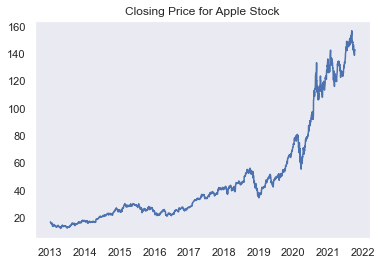

In [56]:
plt.plot(df.index,df['Adj Close'])
plt.title("Closing Price for Apple Stock")
plt.grid(False)
plt.show()

In [57]:
def plot_moving_average(series,window,plot_intervals=False,scale=1.96):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Moving Average \n Window size = {}'.format(window))
    plt.plot(rolling_mean,'g',label="Rolling Mean trend")

    if plot_intervals:
        mae = mean_absolute_error(series[window:],rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--',label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

        plt.plot(series[window:],label='Actual values')
        plt.legend(loc='best')
        plt.grid(True)

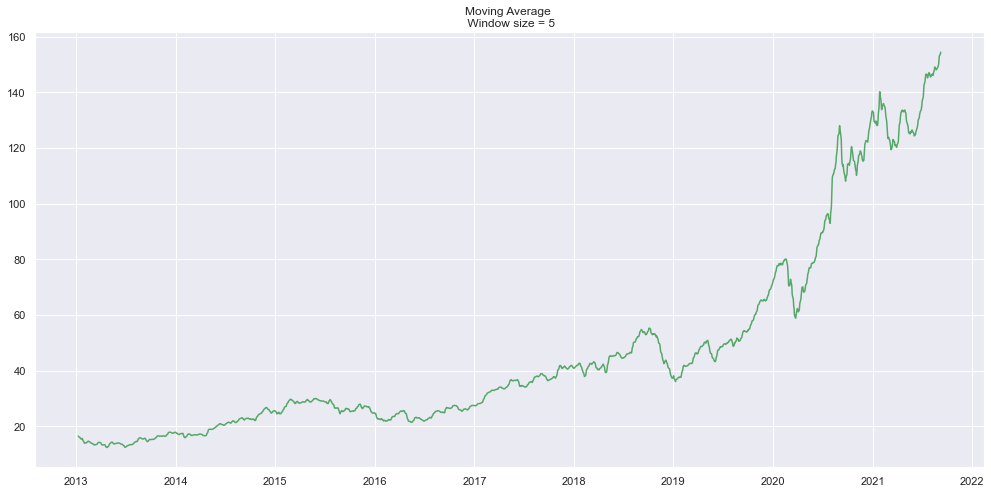

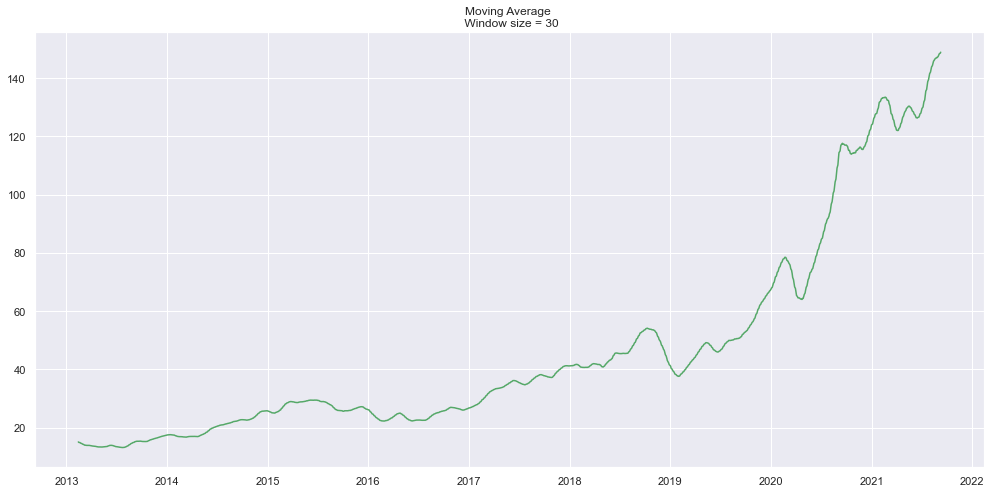

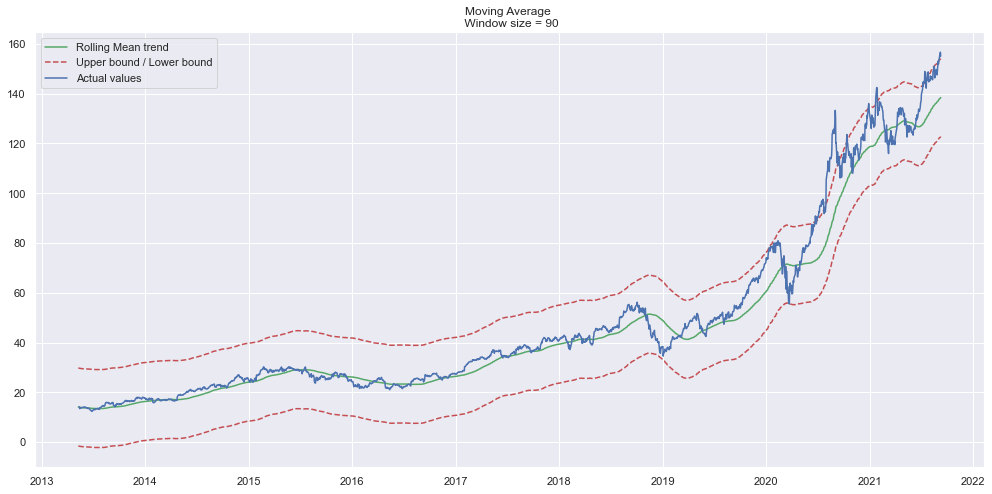

In [58]:
plot_moving_average(train['Adj Close'],5)

plot_moving_average(train['Adj Close'],30)

plot_moving_average(train['Adj Close'],90,plot_intervals=True)

In [59]:
ps = range(0,2)
qs = range(0,2)
Ps = range(0,2)
Qs = range(0,2)
s = 4

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

def optimize_ARIMA(parameters_list,d,D,s):
    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        model = ARIMA(df['Adj Close'],order=(param[0],d,param[1]),seasonal_order=(param[2],D,param[3],s)).fit()

        aic = model.aic

        if aic < best_aic:
            best_aic = aic
        results.append([param, model.aic])

    result_table = pd.DataFrame(results, columns=['parameters','aic'])
    result_table = result_table.sort_values(by='aic',ascending=True).reset_index(drop=True)
    return result_table

In [71]:
result_table_price = optimize_ARIMA(parameters_list,0,0,s)
p,q,P,Q = result_table_price.parameters[0]
train['rtx'] = df['rtx'].loc[train.index[:-1]]
train = train.dropna()
best_model_price = ARIMA(train['Adj Close'],order=(p,0,q),seasonal_order=(P,0,Q,s)).fit()
best_model_vol = ARIMA(train['rtx'],order=(p,1,q),seasonal_order=(P,1,Q,s)).fit()
vol_arima_pred = best_model_vol.forecast(steps=len(test.values))
price_arima_pred = best_model_price.forecast(steps=len(test.values))

  0%|          | 0/16 [00:00<?, ?it/s]

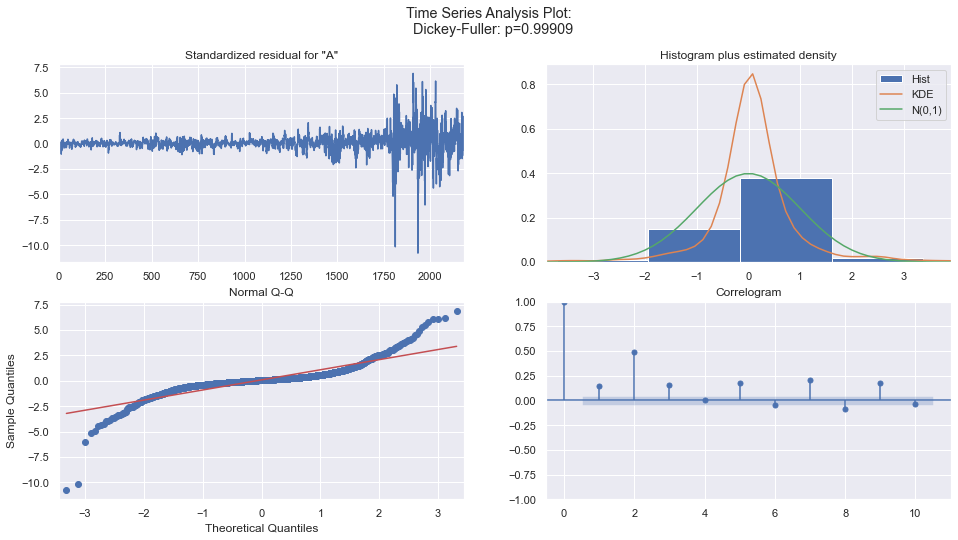

In [67]:
p_value = adfuller(train['Adj Close'])[1]
plt.style = 'bmh'
fig = plt.figure(figsize=(16,8))
fig.suptitle("Time Series Analysis Plot: \n Dickey-Fuller: p={0:.5f}".format(p_value))
best_model_price.plot_diagnostics(fig=fig)
plt.show()

In [68]:
print(best_model_price.summary())

                                    SARIMAX Results                                    
Dep. Variable:                       Adj Close   No. Observations:                 2184
Model:             ARIMA(0, 0, 1)x(1, 0, 1, 4)   Log Likelihood               -4189.115
Date:                         Sat, 26 Mar 2022   AIC                           8388.231
Time:                                 22:33:15   BIC                           8416.675
Sample:                                      0   HQIC                          8398.629
                                        - 2184                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         79.2058     26.682      2.968      0.003      26.910     131.502
ma.L1          0.7377      0.007    109.933      0.000     

In [69]:
resid = best_model_vol.resid.dropna()
model = arch_model(resid,vol='GARCH',p=30,q=30)
res = model.fit(disp='off')
print(res.summary())
forecast = res.forecast(horizon=len(test))
pred_G = np.array(forecast.residual_variance.dropna()).reshape(-1)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4158.90
Distribution:                  Normal   AIC:                           8441.79
Method:            Maximum Likelihood   BIC:                           8794.51
                                        No. Observations:                 2184
Date:                Sat, Mar 26 2022   Df Residuals:                     2183
Time:                        22:33:19   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu         4.5098e-04  8.149e-02  5.534e-03      0.996 [ -0.159,  0.16

[]

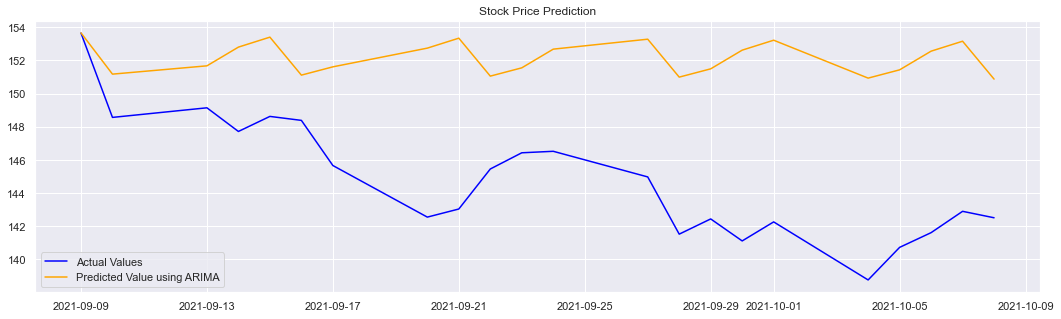

In [72]:
test['Price Prediction'] = price_arima_pred.values
fig = plt.figure(figsize=(18,5))
plt.plot(test['Adj Close'], color="blue",label="Actual Values")
plt.plot(test['Price Prediction'], color="orange",label="Predicted Value using ARIMA")
plt.title("Stock Price Prediction")
plt.legend()
plt.plot()

[]

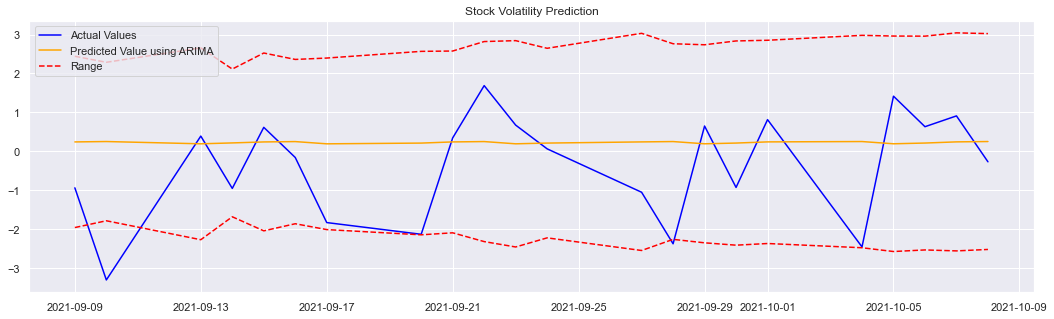

In [65]:
test['Vol Prediction'] = vol_arima_pred.values
test['Upper'] = vol_arima_pred.values + pred_G
test['Lower'] = vol_arima_pred.values - pred_G
test['rtx'] = df['rtx'].loc[test.index]
fig = plt.figure(figsize=(18,5))
plt.plot(test['rtx'], color="blue",label="Actual Values")
plt.plot(test['Vol Prediction'], color="orange",label="Predicted Value using ARIMA")
plt.plot(test['Upper'], color="red",linestyle="--",label="Range")
plt.plot(test['Lower'], color="red",linestyle="--")
plt.title("Stock Volatility Prediction")
plt.legend()
plt.plot()